## Understanding online communication between OpenStreetMap contributors:<br>A computational analysis of changeset discussions from the United States
By Hannah Ker


<a id='top'></a>
## Table of Contents 

[1 | Introduction](#intro) <br>
[2 | Research Question](#rq) <br>
[3 | Collection and Presentation of Data](#data) <br>
[4 | Methodology](#methods) <br>
[5 | Results](#results) <br>
[6 | Discussion](#discussion) <br>
[7 | Conclusion](#conclusion) <br>
[8 | References](#references) <br>

_This notebook takes approximately 3 minutes to run_.

<a id='intro'></a>
***

## 1 | Introduction

***

We analyze communication patterns between OpenStreetMap (OSM) contributors relating to their mapping activities. Since 2014, contributors have had the ability to engage in public discussions directly related to a given OSM changeset. A changeset is a discrete group of edits made by a single contributor within a short period of time (“Changeset,” n.d.). As described in the blog post introducing this feature, changeset discussions are intended to be a place for “welcoming new users”, “leaving positive feedback”, and “asking questions about controversial edits” (“Introducing Changeset Discussions,” 2014). New mappers may also flag their map edits to request feedback from more experienced mappers (Neis, 2017a). While this feature has been present for almost six years, there has been little large-scale, empirical investigation into whether or not this communication tool is being used as intended. 

Given the importance placed on building community within the OSM project (“Join the community,” n.d.), it is relevant to research existing modes of engagement between contributors. Survey research has found that, particularly among more experienced OSM mappers, community engagement is a key motivator for sustained contribution to the project (Budhathoki and Haythornthwaite, 2013). While OSM has been well-researched with respect to topics such as the quality and applications of its data (eg. Haklay, 2010; Luxen and Vetter, 2011; Rahman et al., 2012), the characteristics of community interactions have received much less attention from researchers. Existing analyses of changeset discussions are limited to descriptive and summary statistics (Neis, 2018, 2017b). There is thus much room for more in-depth research. It is worth noting that OSM contributors may engage with each other in a variety of ways, such as through mailing lists, wikis, and in-person mapping events. To reduce the scope of our analysis, we restrict our focus to communication through changeset discussions. 

The results of this analysis may also have implications for ongoing efforts to promote inclusion in OSM (as evidenced by the recent appointment of a “Diversity and Inclusion Special Committee”) (“Diversity and Inclusion Special Committee,” n.d.). Research has found that the vast majority of OSM contributors are male (Budhathoki and Haythornthwaite, 2013; Gardner et al., 2019). Research relating to Wikipedia, a similar online crowdsourcing project, has found that many women have stopped contributing due to experiences of conflict with other contributors during online discussions (Collier and Bear, 2012). There is thus a need to identify the prevalence of conflict and negative interactions within OSM changeset discussions.

Moreover, past work in the context of Wikipedia validates the use of computational methods to analyze large volumes of text data to better understand communication in online crowdsourcing communities. For example, Wang and Cardie (2016) investigate online disputes on Wikipedia talk pages using a sentence-level sentiment analysis, and Kittur et al. (2007) use SVM to identify incidences of user conflict on edits in Wikipedia.  

We hope that this unique analysis can further understandings of the ways that members of the OSM community interact online and build community. As our analysis addresses salient issues in the community such as gender inclusion and newcomer retention, we also hope that this work can contribute to efforts to make OSM a more inclusive and welcoming community. 

<a id='rq'></a>
***

## 2 | Research Question

***

Throughout this work, we seek to answer the following research question: _What is the subject and tone of OSM changeset discussions between contributors in the United States over the past 90 days?_

<a id='data'></a>
***

## 3 | Collection and Presentation of Data 

***

We use web scraping to collect unstructured changeset discussions from the United States over a 90-day period. Note that the following code to complete the web scraping is commented and included here for exemplary purposes. As the scraping takes a significant amount of time, we will load in a previously scraped CSV file for our presentation and analysis. We then reveal the key characteristics of our dataset through basic summary statistics and visualizations.

We will begin by loading all the packages required throughout this exercise: 

In [1]:
# Potential package downloads
# conda install -c conda-forge joypy
# conda install -c conda-forge gensim
# conda install -c conda-forge bs4
# conda install -c conda-forge langdetect
# conda install -c conda-forge nltk
# conda install -c conda-forge pyLDAvis
# nltk.download('punkt')
# nltk.download('stopwords') # for the stopwords 
# nltk.download('averaged_perceptron_tagger') # for pos tagging
# nltk.download('wordnet') # for lemmatizing

In [2]:
# Data collection
from bs4 import BeautifulSoup
import requests

# Text cleaning and exploration
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from langdetect import detect
from nltk.corpus import wordnet

# Analysis
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import gensim
from nltk.sentiment.vader import SentimentIntensityAnalyzer, SentiText

# Visualization
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
import joypy
from pprint import pprint
plt.style.use('fivethirtyeight')
%matplotlib inline

# Text printing
from IPython.display import Markdown, display

# General data processing 
import pandas as pd
from statistics import stdev, mean
import string
import csv

### 3.1 | Data Collection
***

We use the Latest OSM Changeset Discussions/Comments webpage from Pascal Neis to direct us towards URLs for changesets with comments in the US over the last 90 days (which is the longest historical timeframe) (“Latest OpenStreetMap (OSM) Changeset Discussions/Comments,” n.d.).

In [3]:
def getChangesets(url):
    '''Gets a list of changesets, in url format'''
    
    page = requests.get(url) # Load the webpage 
    soup = BeautifulSoup(page.content, 'html.parser') # Parse the HTML DOM of the page   
    changesets = [] # Initialize output list 

    for link in soup.find_all('a'): # Get all 'a' tags with the 'view changeset' title
        if link.get('title') == "View changeset":
            changesets.append(link.get('href')) # Append the link to the output list 
        
    return(changesets)

In [4]:
# Get all the changesets 
# http://resultmaps.neis-one.org/osm-discussions?c=United%20States&d=90#3/47.40/-117.51

# ------------ Code previously run ---------------
# changesets = getChangesets('http://resultmaps.neis-one.org/osm-discussions?c=United%20Kingdom&d=90#5/54.145/-3.000')

Once we have the list of changeset URLs, we can scrape the comment thread for each changeset. We do this by identifying unique HTML elements in the page that characterize the location of the comments. The data is then stored in an n-dimensional list format. Each discussion thread is made up of a list of individual comments, which is then stored as part of a list of all discussion threads. 

In [5]:
def getComments(url):
    '''Gets all of the comments for a given changeset'''

    try: 
        page = requests.get(url, timeout=10) # Get the html page
        soup = BeautifulSoup(page.content, 'html.parser') # Format for parsing

        if page.status_code != 200:
            return False
        
        text = soup.find_all('div', class_='changeset-comments') # Get the div with the changeset comments
        a = text[0].find_all('li') # Get all of the comments 
        b = [] # List to store all the comments
        for x in a:  # Parse the comments text 
            y = x.find_all('p') # Get the paragraphs
            text = ""
            for z in y: # Concatenate all the paragraphs in a comment 
                text+=(" " + z.get_text().replace('\n', ' '))
            b.append(text)
        return(b)
    
    except: # Will get here if the get request times out
        print('timed out')
        return
    

In [6]:
# Get all the comments - depending on how much data, this takes a bit of time 

# ------------ Code previously run ---------------
# allComments = []

# for changeset in changesets: 
#     allComments.append(getComments(changeset))

Once the data has been scraped, we will write it to a CSV file for more durable storage. 

In [7]:
# Each row in the csv is a comment thread for a changeset. 
# Multiple comments for the same changeset extend to subsequent columns in the row

# ------------ Code previously run ---------------
# with open('uk_comments_90.csv', 'w', newline='') as f:
#    writer = csv.writer(f)
#    for comment in allComments:
#        if comment is not None:
#            try:
#                writer.writerow(comment)
#            except: # breaks when comments contain emojis
#                print(comment)

### 3.2 | Presentation of Data
***

We first open the CSV file that we created in the previous step and store the data in a new variable.

In [8]:
# Open the CSV file created in Part 1 and store in nested list format
with open('us_comments_90.csv', 'r', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    allComments = [row for row in reader]

We print out a given thread to make sure that the data looks like what we are expecting. We can also use this as an opportunity to manually look at an example of what people are talking about in these comments. As shown below, we can see that contributors are discussing the justification behind a given edit in Alaska. 

In [9]:
def printThread(thread):
    '''Prints all the comments in a thread in a markdown table format for readability.'''
    
    toprint = '''Thread | 
                :-- |''' # Markdown formatting 
    
    for i in range(0,len(thread)): # Loop through all comments in the thread 
        toprint=toprint+('\n' + thread[i])
        
    display(Markdown(toprint))

printThread(allComments[78])

Thread | 
                :-- |
 Hi AlaskaDave, what was the argument for deleting https://www.openstreetmap.org/way/8996056/history#map=15/61.0828/-146.3000 ? Related: https://www.openstreetmap.org/note/242131
 Well, I don't recall. I did drive through that area and made a ton of edits. It's possible I didn't see any track or "footway": when I was there. As you know, Tiger tracks are scattered all over Alaska and are sometimes positioned in terrain where its possible to see that it isn't there now and simply never was there. The North Slope, for example, is full of such "tracks". I try to align them using existing imagery when they are visible but I sometimes just delete them.
 Sounds fair, stay safe!

The table below provides a summary of some basic characteristics of our dataset. We have collected a total of 2020 discussion threads, with a total of 2974 comments. 

In [10]:
# Across the whole dataset, what are the comment and thread lengths?
tlengths, clengths, counter = [], [], 0

# Loop through the data and count for each variable
for thread in allComments:
    counter+=len(thread) # Total number of comments
    tlengths.append(len(thread))# Thread length
    for comment in thread:
        clengths.append(len(word_tokenize(comment))) # Words in comments

# Add the totals, averages, and standard deviations to a dataframe for clear output in a table
summary = [('Threads', len(allComments), str(round(mean(tlengths),2)) + ' comments', str(round(stdev(tlengths),2))), 
        ('Comments', counter, str(round(mean(clengths),2)) + ' words', str(round(stdev(clengths),2)))]

# Create and show the dataframe
summary = pd.DataFrame(summary, columns =['Variable', 'Total number', 'Average length', 'Standard deviation']) 
summary # Show the dataframe 

,Variable,Total number,Average length,Standard deviation
0,Threads,2020,1.47 comments,1.16
1,Comments,2974,45.23 words,54.97


As shown by the following two figures, we can see that the length of each comment and the number of comments in each thread have highly skewed distributions. Most comments contain under 100 words. The vast majority of threads only contain one comment, and very few threads have more than 6 comments. 

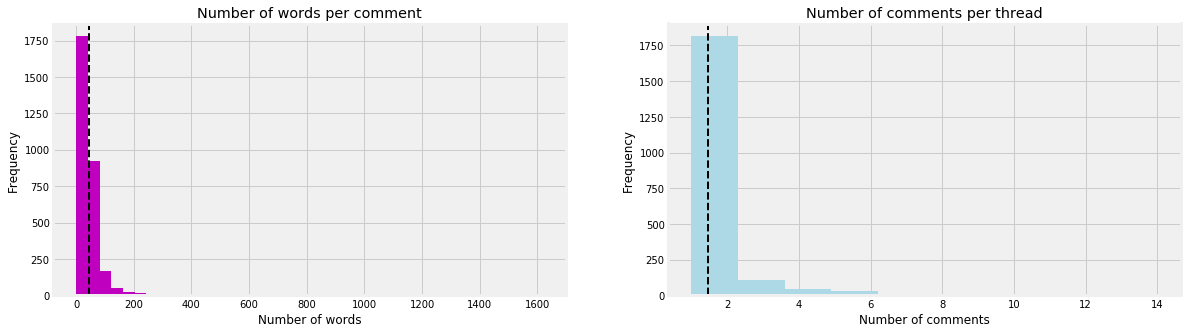

In [11]:
# Histograms for distribution of words/comment and comments/thread
plt.figure(figsize=(18, 5)) # sizing for the figures

# First figure
plt.subplot(121)
plt.hist(clengths, density=False, bins=40, color='m');
plt.axvline(mean(clengths), color='k', linestyle='dashed', linewidth=2)
plt.ylabel('Frequency');
plt.xlabel('Number of words');
plt.title('Number of words per comment');

# Second figure
plt.subplot(122)
plt.hist(tlengths, density=False, bins=10, color='lightblue');
plt.axvline(mean(tlengths), color='k', linestyle='dashed', linewidth=2)
plt.ylabel('Frequency');
plt.xlabel('Number of comments');
plt.title('Number of comments per thread');

[Return to top](#top) <br>

<a id='methods'></a>
***

## 4 | Methodology

***

Our methodology consists of three components. 1) We clean our data to transform it into a format appropriate for topic modelling. 2) We apply Latent Dirichlet Allocation (LDA) to detect commonly occurring topics in these changeset discussions. 3) We then use a rule-based sentiment analysis model to understand the emotional tone of each discussion in our dataset.

Note that due to the presence of randomness in the models used for some data cleaning steps (eg. bigrams and lemmatization), slightly different results may be obtained with different runs. To ensure reproducibility of our exact results, we save the cleaned datasets from one run, and use this data to generate our LDA model and perform our sentiment analysis.

### 4.1 | Data cleaning
***

The unstructured and messy nature of this text data requires significant cleaning before it is suitable for our topic modelling exercise. The aim of this data cleaning is to remove noise, break text down into uniform units, and normalize words by reducing them to a root form. These techniques all contribute to the creation of highly structured representations of the raw text data that we initially collected (Feldman and Sanger, 2006). The Natural Language Toolkit (NLTK) is used throughout the data cleaning process to aid with technical implementation (Loper and Bird, 2002). 

We conduct data cleaning operations in two phases. In the first phase, we 1) filter out non-English text, 2) convert all characters to lowercase, 3) separate all text into individual words through tokenization, 4) remove all punctuation and words with non alphabetic characters, 5) remove duplicate discussion threads, and 6) remove all stop-words. Stop-words are commonly used words, such as ‘a’ and ‘the’ that have little meaning on their own. We use the English stop-words list provided by NLTK, with a couple additions that are relevant to our context. An algorithm to remove duplicates in a list has been adapted from Stack Overflow (“How do you remove duplicates from a list whilst preserving order?,” n.d.).

In [12]:
# Get list of English stop words
stop_words=set(stopwords.words("english"))
stop_words.add('https') # Add these because they come up in the text
stop_words.add('http')

In [13]:
# Functions for first pass of data cleaning
def toLowercase(comment):
    '''Converts all characters in a string to lowercase.'''
    return(comment.lower())

def isEnglish(comment):
    '''Returns boolean indicating if a string is English or not.'''
    try:
        if detect(comment) != 'en':
            return(False)
        return(True)
    except: # Hits error when irregular characters, like emojis, are encountered
        return(False)

def tokenize(comment):
    '''Converts a text string into a list of individual words.'''
    return(word_tokenize(comment))

def remove(tokenized):
    '''Removes punctuation or words with not alphabetic characters from tokenized text.'''
    return([word for word in tokenized if word not in stop_words and word.isalpha()])

In [14]:
# Remove duplicate threads while preserving the ordering 
# Adapted from: https://stackoverflow.com/questions/480214/how-do-you-remove-duplicates-from-a-list-whilst-preserving-order
def unique_threads(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [15]:
# Join all comments in a thread together
def joinThread(thread):
    '''Returns a single string with all comments in the thread combined'''
    joined = ''    
    for comment in thread:
        joined += comment   
    return(joined)

joined = [joinThread(thread) for thread in allComments] # Merge all threads into one string, one list item for each thread

In [16]:
# Remove duplicate threads from the corpus
no_dups = unique_threads(joined)
print('All threads: ' + str(len(joined)))
print('Unique threads: ' + str(len(no_dups)))

All threads: 2020
Unique threads: 1542


In [17]:
# Do first pass of cleaning
allEnglish = [thread for thread in no_dups if isEnglish(thread)] # Remove non-English text 
cleaned_1 = [remove(tokenize(toLowercase(thread))) for thread in allEnglish] # Perform other cleaning 

print('After 1st cleaning: ' + str(len(cleaned_1)) + ' threads')

After 1st cleaning: 1518 threads


In the second phase of our data cleaning, we identify common two and three-word phrases (bigrams and trigrams, respectively), and lemmatize each word. Lemmatization aims to normalize word derivations and remove the inflections to reduce all words to their base form (Manning et al., 2008). For example, the words “am”, “are”, and “is” can all be reduced to the base “be” (Manning et al., 2008). As lemmatization performs a morphological analysis of words, each word must first be tagged with its associated part of speech (POS) (eg. noun or verb) (Prabhakaran, 2018a). While stemming, a competing approach to word normalization, may in some cases give more favourable results (Manning et al., 2008), we found that the outputs of word stemming were less interpretable than with lemmatization.

We use NLTK’s WordNetLemmatizer and POS-tagger to perform these functions (following Prabhakaran, 2018a). We use Gensim’s Phraser model, trained on our entire corpus, to detect bigrams and trigrams in our text. As indicated by the links provided in the code, technical implementation is further aided by Prabhakaran (2018c, 2018b). 

In [18]:
# Build the bigram model
# Adapted from: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
bigram = gensim.models.Phrases(cleaned_1, min_count=10, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram = gensim.models.Phrases(cleaned_1, min_count=10, threshold=100)  
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [19]:
# Functions for finding bigrams and lemmatizing
# Adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# Adapted from https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def findBigrams(tokenized):
    '''Identifies bigrams in tokenized text.'''
    return bigram_mod[tokenized]

def findTrigrams(tokenized):
    '''Identifies trigrams in tokenized text.'''
    return trigram_mod[tokenized]

def wordnetPOS(word):
    '''Does POS tagging for a word and converts to proper format for .lemmatize()'''
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def toLemmatize(tokenized):
    '''Converts text tokens into their lemma.'''
    return([WordNetLemmatizer().lemmatize(w, wordnetPOS(w)) for w in tokenized])

In [20]:
# Do second pass of cleaning the data
cleaned_2 = [toLemmatize(findTrigrams(findBigrams(words))) for words in cleaned_1]

print('After 2nd cleaning: ' + str(len(cleaned_2))+ ' threads')

After 2nd cleaning: 1518 threads


Below, we see some examples of the bigrams and trigrams that were found in our text. 

In [21]:
# Check out the bigrams and trigrams   
phrases = [word for thread in cleaned_2 for word in thread if '_' in word]

print('Phrases include: ' + phrases[21] + ', ' + phrases[12] + ', ' + phrases[67])

Phrases include: square_corners, seo_spam, press_q


The following function will allow us to more closely inspect our cleaning process, by investigating how a given comment is transformed. The example below demonstrates how this function structures each comment into a list of words, and removes noisy information such as web links and punctuation marks. We can see how words such as 'if' and 'the' have been removed from the text. The word 'corners' had been normalized to 'corner', and all resulting tokens contain only alphabetical characters. The phrase 'q_key' has been picked up as a bigram, indicating that many comments contain this two-word phrase. While the resulting data is less readable to the human eye, its standardized format will be more appropriate for a computational analysis. 

In [22]:
# Visual verification of cleaning process
def checkClean(comment):
    '''Print out all cleaning steps for one comment, to check that things are working as expected.'''
    toprint = '''Preprocessing Step | Output |
                :-- |:-- |'''
    toprint +=("\n ORIGINAL COMMENT | " + comment + '|')
    toprint +=("\n LOWERCASE | " + toLowercase(comment) + '|')
    toprint +=("\n TOKENIZED | " + str(tokenize(toLowercase(comment))) + '|')
    toprint +=("\n NO STOP WORDS OR PUNCT | " + str(remove(tokenize(toLowercase(comment)))) + '|')
    toprint +=("\n WITH BI/TRIGRAMS | " + str(findBigrams(remove(tokenize(toLowercase(comment))))))
    toprint +=("\n LEMMATIZED | " + str(toLemmatize(findBigrams(remove(tokenize(toLowercase(comment)))))))      
    display(Markdown(toprint))

checkClean(joined[45])

Preprocessing Step | Output |
                :-- |:-- |
 ORIGINAL COMMENT |  Just a tip...those buildings will look better if the corners are squared up. Just select and press the Q key. Thanks.|
 LOWERCASE |  just a tip...those buildings will look better if the corners are squared up. just select and press the q key. thanks.|
 TOKENIZED | ['just', 'a', 'tip', '...', 'those', 'buildings', 'will', 'look', 'better', 'if', 'the', 'corners', 'are', 'squared', 'up', '.', 'just', 'select', 'and', 'press', 'the', 'q', 'key', '.', 'thanks', '.']|
 NO STOP WORDS OR PUNCT | ['tip', 'buildings', 'look', 'better', 'corners', 'squared', 'select', 'press', 'q', 'key', 'thanks']|
 WITH BI/TRIGRAMS | ['tip', 'buildings', 'look', 'better', 'corners', 'squared', 'select', 'press_q', 'key', 'thanks']
 LEMMATIZED | ['tip', 'building', 'look', 'well', 'corner', 'square', 'select', 'press_q', 'key', 'thanks']

We save two versions of our cleaned dataset to CSV files to be subsequently loaded in our analysis. 

In [23]:
# Save the fully cleaned and tokenized text for topic modelling 
# ------------ Code previously run ---------------
# with open('cleaned_2_d.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#    for comment in cleaned_2:
#        if comment is not None:
#            try:
#                writer.writerow(comment)
#            except:
#                print(comment)
                
# Save the English, non duplicate threads for sentiment analysis 
#df = pd.DataFrame(data={"threads": allEnglish})
#df.to_csv("allEnglish.csv", sep=',',index=False, header=False)

### 4.2 | Topic modelling
***

We use Latent Dirichlet Allocation (LDA) (Blei et al., 2003) to identify the primary topics in this text data, which contributes to our understanding of the commonly occurring subjects in changeset discussions. LDA has been used as an unsupervised approach to analyze the content of large volumes of text data, such as historical journalistic texts (Jacobi et al., 2016), or academic studies (Mo et al., 2015). LDA is a probabilistic model through which each document in a dataset is assumed to be made up of a number of latent topics (Blei et al., 2003). Each of these topics is represented by a distribution of words (Blei et al., 2003). However, Jacobi et al. (2016) point out that the topics produced by LDA, as determined by word co-occurrence, may reflect a variety of entities, from writing styles to key events to general themes. Thus, it is possible that not all topics produced by the model will be useful for the analysis at hand.  

Moreover, past work has pointed to the challenges of applying LDA to short text documents, such as Tweets, given that documents are unlikely to contain multiple topics (Naveed et al., 2011). Following the positive findings from Hong and Davison (2010), we address this problem by aggregating all comments in a single thread into one document.  We acknowledge that many discussion threads in our dataset will still be quite short, given the fact that a large number only contain one comment.  

We use Gensim’s LDA model (Řehůřek and Sojka, 2011) in our analysis and begin by creating the two necessary model inputs: 1) a mapping of every unique word in our dataset to a numerical ID, and 2) a document-term matrix, containing the IDs and number of occurrences for each word in each document. In our case, a ‘document’ corresponds to a discussion thread. 

We also set the range of values for key model hyperparameters. The primary hyperparameter is the number of topics (K) for the model to identify. Given the relatively small size of our corpus and the desire for distinct and interpretable topics, we identify [5,15] as the range of potential K values. The second hyperparameter, alpha,  reflects the assumed number of topics in each document (Jacobi et al., 2016). We set the alpha hyperparameter using Gensim’s ‘auto’ default to automatically assign this value based on our input dataset. 

As indicated by the links provided in the code, the technical implementation of LDA is aided by Prabhakaran (2018b).

In [24]:
# Load in the saved cleaned data 
with open('cleaned_2.csv', 'r', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    cleaned_2_ = [row for row in reader]

In [25]:
# Create required inputs for Gensim topic model
# Adapted from: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

id2word = corpora.Dictionary(cleaned_2_) # Mapping between unique words and IDs
corpus = [id2word.doc2bow(words) for words in cleaned_2_] # Document-term matrix
topicNums = range(5,15,1) # Potential number of topics to check

print("Total number of documents: " + str(len(corpus)))
print("Total number of unique words: " + str(len(id2word)))

Total number of documents: 1520
Total number of unique words: 4389


We now create LDA models for our range of K values. We compare model performance using the topic coherence metric, implemented using Gensim and following the approach in Röder et al. (2015). We select topic coherence as our evaluation metric as work has found that optimizing for the common alternative, perplexity, can result in topics that are less interpretable (p. 2, Chang et al., 2009).

In [26]:
# Build LDA model - test different topic numbers and compare by model coherence 
# Adapted from: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python
def testLDA(topics):
    scores = []
    for num in topics:
        # Create the topic model
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            iterations=300,
                                            num_topics=num, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
        # Calculate model coherence
        coherence_model_lda = CoherenceModel(model=lda_model, texts=cleaned_2, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        scores.append(coherence_lda)
        
    return scores

coh = testLDA(topicNums)

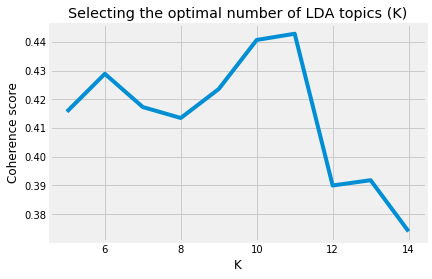

In [27]:
# Print the results 
fig, ax = plt.subplots()
ax.plot(topicNums, coh)

ax.set(xlabel='K', ylabel='Coherence score',
       title='Selecting the optimal number of LDA topics (K)')
plt.show()

The figure above indicates that an LDA model with 11 topics (K=11) is most optimal. We create our final model with this hyperparameter. 

In [28]:
# Create the topic model with optimal K value 
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=11,
                                    iterations=300,
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)

### 4.3 | Sentiment analysis
***

We conduct a sentiment analysis of these changeset discussions to better understand the tone of communication between OSM contributors. We employ an unsupervised, rule-based method, the Valence Aware Dictionary for sEntiment Reasoning (VADER), that has been designed to detect sentiment in social media text (Hutto and Gilbert, 2014). This model is thus well-suited to our data, which is also often short and informal. VADER provides fine-grained sentiment scores for input text that range on a continuous scale from -1 (highly negative) to +1 (highly positive). In calculating these scores, VADER uses rules that account for the following scenarios: 1) punctuation and capitalization increasing magnitude of intensity, 2) impact of modifiers before adjectives, such as “extremely good” vs “moderately good”, 3) the impact of a contrastive conjunction, such as, “the movie was good, but…”, and 4) negation, such as, “the movie was not good” (Hutto and Gilbert, 2014). When applied to the analysis of Tweets, Amazon reviews, movie reviews, and NYTimes editorials, VADER has been found to perform competitively against state-of-the-art machine learning models such as SVM and Naïve Bayes (Hutto and Gilbert, 2014). VADER has thus been proven to generalize well across contexts (Hutto and Gilbert, 2014). The clarity of this model’s decision making and speed of analysis also provide advantages to machine learning models. 

As VADER has been designed for use with unstructured social media data, we do not apply the same rigorous cleaning processes that were performed for the topic modelling. Rather, we simply use a version of our dataset that has had duplicates and non-English text removed. 

In [29]:
# Read in saved data
allEnglish_ = pd.read_csv('allEnglish.csv', header=None).values.tolist()

In [30]:
# Function to calculate the aggregate sentiment score for each comment thread
def calcSentiment(comment):
    '''Calculate the polarity score for a comment. Returns comment and associated score.'''
    return([comment, SentimentIntensityAnalyzer().polarity_scores(comment)['compound']])

In [31]:
# Apply the function above and generate lists holding comment + associated score, and just the scores
sentiments, scores = [], []

for thread in allEnglish_:
    sentiments.append(calcSentiment(thread[0]))
    scores.append(calcSentiment(thread[0])[1])

[Return to top](#top) <br>

<a id='results'></a>
***

## Part 5 | Results

***

The following section provides a review of the primary results from our topic modelling and sentiment analysis of OSM changeset discussions. 

We use the pyLDAvis library to visualize the results of our topic modelling (Sievert and Shirley, 2014). As described by Sievert and Shirley (2014), the left panel of this visualization projects all topics onto a two-dimensional space to provide a global view of all topics and their distances to each other. The size of each topic circle corresponds to the prevalence of each topic in the entire corpus (ie. our dataset of changeset discussions). When the user hovers over a topic circle, the bar chart on the right panel of the visualization indicates the most frequently occurring terms within that topic. These terms are ranked according to saliency, as defined in Chuang et al. (2012).  

From this visualization we can see that the overlapping topics 7 and 4 are most prevalent in our dataset, containing 25.6% and 36.4% of all words, respectively. We also see a cluster of six comparatively small topics in the bottom right corner of the panel.  

In [32]:
# Visualize the results of the LDA 
pyLDAvis.enable_notebook();
vis = pyLDAvis.gensim.prepare(lda_model, corpus, lda_model.id2word, sort_topics=False);
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.118750  0.014183       1        1   2.219461
1     -0.051980 -0.149940       2        1   6.763063
2      0.131512 -0.061667       3        1   3.567082
3     -0.279913 -0.085289       4        1  34.649860
4     -0.092830  0.333061       5        1  10.469932
5      0.125528 -0.055481       6        1   3.352907
6     -0.305649 -0.049410       7        1  25.591850
7      0.121271 -0.015083       8        1   1.667040
8      0.037563  0.146749       9        1   5.676897
9      0.078331 -0.074487      10        1   4.509635
10     0.117418 -0.002637      11        1   1.532278, topic_info=          Term        Freq       Total Category  logprob  loglift
132        osm  558.000000  558.000000  Default  30.0000  30.0000
91      please  710.000000  710.000000  Default  29.0000  29.0000
3     building  430.000000  430.000000  Default  28.0000  28.0000
16         tag  932.000000  932.000000  Default  27.0000  27.0000
215    welcome  345.000000  345.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
520     preset    2.709109    3.574556  Topic11  -5.5250   3.9012
841   together    2.706369    3.571840  Topic11  -5.5260   3.9009
4139   recheck    2.676123    3.542191  Topic11  -5.5373   3.8980
2368    degree    2.672698    3.538220  Topic11  -5.5385   3.8979
31         lot   12.158998  101.055321  Topic11  -4.0236   2.0608

[428 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3730      8  0.935572  absolutely
342       5  0.992370      access
1791      3  0.963759    accurate
26        9  0.985549      actual
20        4  0.729131         add
...     ...       ...         ...
101       4  0.995188       would
165       9  0.993244       wrong
3485     11  0.931792     wyoming
581       9  0.979105        year
25       11  0.885976        zoom

[448 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

The table below provides a summary of our interpretation of each of the LDA topics, indicating key attributes such as the general theme and ease of interpretation of each topic. We interpret each topic using the top relevant terms and relative positions indicated in the figure above. We see that the majority of topics address either map subjects (ie. elements of the map) or map activities (ie. editing processes). Overlapping topics 3 and 6 could be combined into a single topic relating to satellite imagery.  

In [33]:
# Read in the csv with interpretation
lda_interpretation = pd.read_csv("lda_interpretation.csv")
lda_interpretation

,Topic number,Topic tag,Topic theme,Words informing interpretation,Ease of interpretation,Topic size (%)
0,1,pathways,Mapping subject,sidewalk; bridge; footways; footpath; link,Moderate,2.20%
1,2,introductions,Communication,osm; please; welcome; name; help,Challenging,6.80%
2,3,satellite imagery b,Mapping activity,imagery; aerial; bing; esri; trace; topo,Easy,3.60%
3,4,basic map elements,Mapping subject,tag; add; way; node; relation; area,Easy,34.60%
4,5,roads a,Mapping subject,road; access; way; driveway; private,Moderate,10.50%
5,6,satellite imagery a,Mapping activity,imagery; satellite; mapbox; gps; adjust,Easy,3.40%
6,7,basic map activities,Mapping activity,changeset; publish; change; correct; edit; map...,Easy,25.60%
7,8,railway and challenges,Mapping subject/Emotional tone,railway; vandalism; sadly; unaware; crossing; ...,Challenging,1.70%
8,9,buildings,Mapping subject,building; shop; geometry; corner; store; floor...,Easy,5.70%
9,10,roads b,Mapping subject,mph_button; limit; mph; direction; speed,Moderate,4.50%


Next, we can see the overall distribution and mean of the polarity scores from our sentiment analysis. This figure shows that a notable majority of the changeset discussion threads are neutral in sentiment. The distribution is skewed, with more discussion threads assigned positive scores than negative. 

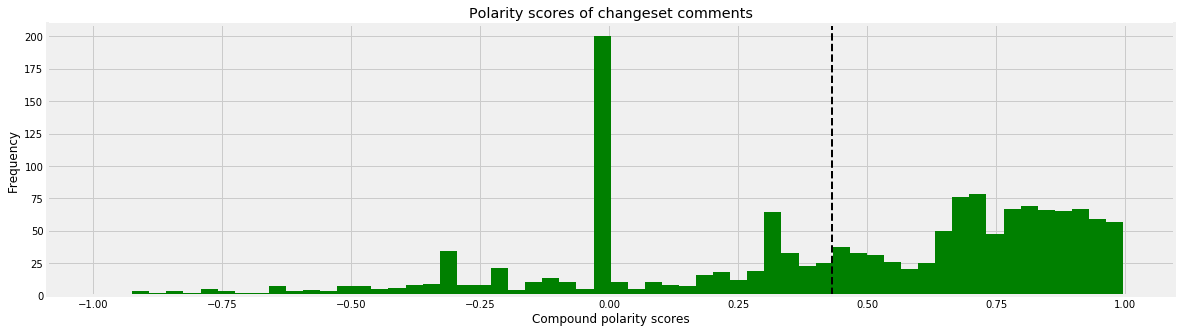

In [34]:
plt.figure(figsize=(18, 5))
plt.hist(scores, density=False, bins=60, color='g');
plt.axvline(mean(scores), color='k', linestyle='dashed', linewidth=2)
plt.ylabel('Frequency');
plt.xlabel('Compound polarity scores');
plt.title('Polarity scores of changeset comments');

We now combine the results of the topic modelling with those from the sentiment analysis to better understand how the two correspond. We first classify each discussion thread according to its dominant topic, then link that to the overall polarity score for the thread. The graph below shows us the distribution of polarity scores for each topic. We see that many of the topics have a comparatively large number of threads with neutral polarity scores. The ‘pathways’ topic has the most concentrated distribution of polarity scores, and is entirely positive. The implementation of some of this code is aided by Prabhakaran (2018c).

In [35]:
# Create a dataframe with the sentiment score and dominant topic for each discussion threas 
# Adapted from: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models

topics_sent = pd.DataFrame() # Output dataframe

# Get main topic in each document
for i, row_list in enumerate(lda_model[corpus]):
    row = row_list[0] if lda_model.per_word_topics else row_list            
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the dominant topic and % contribution for each thread
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0: 
            topics_sent = topics_sent.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
        else:
            break

sent = pd.Series(scores)
topics_sent = pd.concat([topics_sent, sent], axis=1) # Add sentiment scores 
topics_sent.columns = ['topic', 'Perc_Contribution', 'sentiment'] # Rename the columns

topic_vals = lda_interpretation['Topic tag'] # Get the topics tags 
replaced = topics_sent["topic"].replace({0: topic_vals[0], 1: topic_vals[1], 2: topic_vals[2], 3: topic_vals[3], 4: topic_vals[4], 5: topic_vals[5], 6: topic_vals[6], 7: topic_vals[7], 8: topic_vals[8], 9: topic_vals[9], 10: topic_vals[10]})
tagged = pd.concat([topics_sent, replaced], axis=1)
tagged.columns = ['topic', 'Perc_Contribution', 'sentiment', 'tag'] # Rename the columns

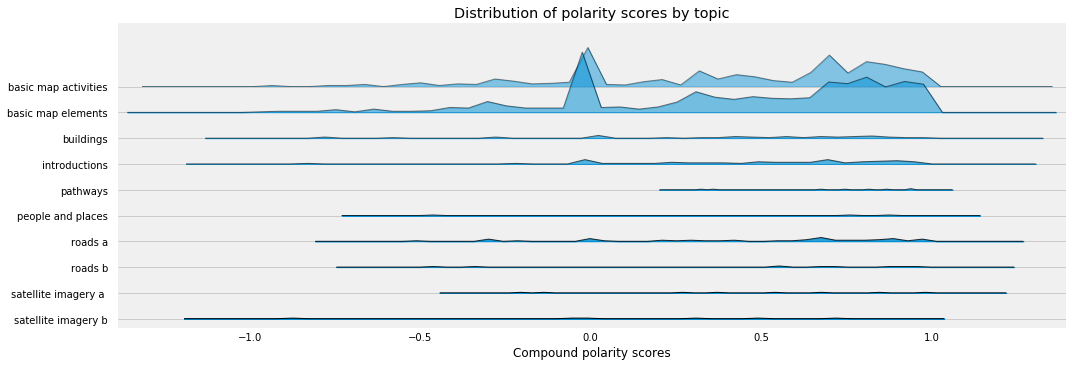

In [36]:
# Create joyplot
fig, axes = joypy.joyplot(tagged, by="tag", column="sentiment",figsize=(15,5), range_style='own', 
                          grid="y", linewidth=1, legend=False,fade=True,
                          title="Distribution of polarity scores by topic",
                          kind="counts", bins=50)
plt.xlabel('Compound polarity scores');
plt.show()

[Return to top](#top) <br>

<a id='discussion'></a>
***

## Part 6 | Discussion

*** 

### 6.1 | Implications of findings 
***

Our findings indicate that OSM changeset discussions are largely being used as intended. Contributors are most frequently discussing map elements and procedures that are part of the mapping process. Elements such as buildings, roads, and pathways feature prominently in discussion threads. 

The presence of topics relating to satellite imagery suggests that many contributors are mapping remotely by tracing satellite imagery. Given that this topic is featured in discussions, we may infer that some contributors are struggling to trace imagery appropriately or are dealing with inconsistent imagery between providers (eg. between Bing and ESRI imagery). 

Overall, we find a low prevalence of comments with a negative tone. It appears as though many contributors engage productively and politely when discussing changesets to the map, as evidenced by the following excerpts from the large number of positively scored discussion threads: 

> - _Hi, and welcome to OSM! After reviewing the change, it looks like you accidentally dragged the node at the intersection a short distance. I've already undone the change (to keep the road straight). Thanks for editing!_ <br>
> - _I continue to be truly impressed with the combination of local knowledge and good OSM tagging. Please, keep up the great work!_ <br>
> - _I really appreciate this change. Are you converting the nearby parks to the same style? If not, I can create notes for all Orlando parks._

The findings from this analysis indicate that conflict in changeset discussions on OSM may not be as prevalent as in the case of Wikipedia (as suggested by Collier and Bear, 2012; Kittur et al., 2007).

The large volume of neutral comments suggests that many interactions between contributors are predominantly transactional, with focus towards improving map edits. This hypothesis is also supported by the fact that the majority of discussion threads only contain one comment. We also acknowledge that this dataset of changeset discussions is not inherently polarized, as in the case of movie or product reviews, and so is more likely to have a significant volume of neutral content. Given the transactional nature of these discussions, we can infer that this mode of communication not provide much social engagement for OSM contributors. This may contrast the community environment at in-person “mapathons”, which have been framed as social contribution environments (Dittus et al., 2016).

While our analysis finds a low prevalence of negative comments, a manual review of some of these comments reveals tensions between some OSM contributors. For example, a number of discussions address the tension between perceived ‘local’ vs ‘armchair’ (ie. remote) mappers, as shown by the following excerpts: 

> - _You don't work here. You don't live here. You don't survey here. You do not use the transit system here. That is armchair mapping._ <br>
> - _You are coming off as real demanding as an arm chair mapper._ <br>
> - _Please be humble enough to understand that you are engaging in an edit war against local knowledge. Please stop._ <br>

These sorts of comments also reveal tones of territoriality, projecting the sense that some mappers feel ownership over regions of the map that they have contributed to.  

> - _On what basis are you making these changes?_ <br>
> - _You don't touch my stuff and i won't touch yours._ <br>

While not frequently occurring, these types of negative communication point to areas where the community has room to grow to be more inclusive to newcomers. 

### 6.2 | Limitations 
***

It is important to note the limitations of this computational analysis. Firstly, the process of interpreting topic outputs from LDA is highly subjective. A number of topics were challenging to interpret as the collection of keywords did not immediately appear to be related to a distinct theme. 

A manual inspection of some results from the sentiment analysis also reveals that some discussion threads may contain nuanced tones that cannot be easily understood by VADER’s rule-based approach. For example, VADER assigned the following comment a highly positive score. While this comment contains the positively rated words “please” and “thanks”, its tone is somewhat challenging, suggesting that the contributor who made this edit does not have the authority to do so. 

> - _Please tell us why you are deleting these? Thanks._

While this computational approach can be useful in reducing the amount of labour required to summarize large volumes of text, some manual interpretation and inspection is still required to ensure that the results are meaningful. The unsupervised nature of our analysis also makes it challenging to evaluate the accuracy of our results. 

[Return to top](#top) <br>

<a id='conclusion'></a>
***

## Part 7 | Conclusion

***

We have presented an in-depth computational analysis of changeset discussions between OpenStreetMap contributors. We apply LDA to understand the primary subjects in discussion threads, and a rule-based sentiment analysis to understand the distribution in the tone of discussions. Perhaps as expected, we find that discussion threads are often used to discuss common mapping activities and features. Our findings suggest that this mode of communication does not offer much social engagement for contributors, as discussions are often neutral and short. Discussions are largely positive in tone, suggesting that contributors engage in a friendly and constructive manner. Nevertheless, we find the prevalence of some aggression and territoriality that may be intimidating to more inexperienced contributors. 

Future work could extend this analysis beyond the English-speaking, United States context to see if these findings are consistent in different cultural and linguistic settings. Efforts to manually tag a set of training data according to sentiment and topic and conduct a supervised analysis may also produce more accurate results.  

<a id='references'></a>
***

## Part 8 | References

***

Blei, D.M., Ng, A.Y., Jordan, M.I., 2003. Latent Dirichlet Allocation. J. Mach. Learn. Res. 3, 993–1022.

Budhathoki, N.R., Haythornthwaite, C., 2013. Motivation for Open Collaboration: Crowd and Community Models and the Case of OpenStreetMap. Am. Behav. Sci. 57, 548–575. https://doi.org/10.1177/0002764212469364

Chang, J., Gerrish, S., Wang, C., Boyd-graber, J.L., Blei, D.M., 2009. Reading Tea Leaves: How Humans Interpret Topic Models. Adv. Neural Inf. Process. Syst. 288–296.

Changeset [WWW Document], n.d. . OpenStreetMap Wiki. URL https://wiki.openstreetmap.org/wiki/Changeset#Changeset_Discussions (accessed 4.27.20).

Chuang, J., Manning, C.D., Heer, J., 2012. Termite: visualization techniques for assessing textual topic models, in: Proceedings of the International Working Conference on Advanced Visual Interfaces - AVI ’12. Presented at the the International Working Conference, ACM Press, Capri Island, Italy, p. 74. https://doi.org/10.1145/2254556.2254572

Collier, B., Bear, J., 2012. Conflict, criticism, or confidence: an empirical examination of the gender gap in wikipedia contributions, in: Proceedings of the ACM 2012 Conference on Computer Supported Cooperative Work, CSCW ’12. Association for Computing Machinery, Seattle, Washington, USA, pp. 383–392. https://doi.org/10.1145/2145204.2145265

Dittus, M., Quattrone, G., Capra, L., 2016. Social Contribution Settings and Newcomer Retention in Humanitarian Crowd Mapping, in: Spiro, E., Ahn, Y.-Y. (Eds.), Social Informatics, Lecture Notes in Computer Science. Springer International Publishing, Cham, pp. 179–193. https://doi.org/10.1007/978-3-319-47874-6_13

Diversity and Inclusion Special Committee [WWW Document], n.d. . OpenStreetMap Found. URL https://wiki.osmfoundation.org/wiki/Diversity_and_Inclusion_Special_Committee (accessed 5.6.20).

Feldman, R., Sanger, J., 2006. The Text Mining Handbook: Advanced Approaches in Analyzing Unstructured Data / Ronen Feldman, James Sanger. University Press, Cambridge.

Gardner, Z., Mooney, P., De Sabbata, S., Dowthwaite, L., 2019. Quantifying gendered participation in OpenStreetMap: responding to theories of female (under) representation in crowdsourced mapping. GeoJournal. https://doi.org/10.1007/s10708-019-10035-z

Haklay, M., 2010. How Good is Volunteered Geographical Information? A Comparative Study of OpenStreetMap and Ordnance Survey Datasets. Environ. Plan. B Plan. Des. 37, 682–703. https://doi.org/10.1068/b35097

How do you remove duplicates from a list whilst preserving order? [WWW Document], n.d. . Stack Overflow. URL https://stackoverflow.com/questions/480214/how-do-you-remove-duplicates-from-a-list-whilst-preserving-order (accessed 5.6.20).

Hutto, C.J., Gilbert, E., 2014. VADER: A Parsimonious Rule-Based Model for Sentiment Analysis of Social Media Text, in: Eighth International AAAI Conference on Weblogs and Social Media. Presented at the Eighth International AAAI Conference on Weblogs and Social Media.
Introducing Changeset Discussions, 2014. 

OpenStreetMap Blog. URL https://blog.openstreetmap.org/2014/11/02/introducing-changeset-discussions/ (accessed 4.28.20).

Jacobi, C., Atteveldt, W. van, Welbers, K., 2016. Quantitative analysis of large amounts of journalistic texts using topic modelling. Digit. Journal. 4, 89–106. https://doi.org/10.1080/21670811.2015.1093271

Join the community [WWW Document], n.d. . OpenStreetMap Wiki. URL https://wiki.openstreetmap.org/wiki/Join_the_community (accessed 5.6.20).

Latest OpenStreetMap (OSM) Changeset Discussions/Comments [WWW Document], n.d. URL http://resultmaps.neis-one.org/osm-discussions?c=United%20States&d=90#5/-20.978/-121.904 (accessed 5.6.20).

Loper, E., Bird, S., 2002. NLTK: The Natural Language Toolkit. arXiv:cs/0205028.

Luxen, D., Vetter, C., 2011. Real-time routing with OpenStreetMap data, in: Proceedings of the 19th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, GIS ’11. Association for Computing Machinery, Chicago, Illinois, pp. 513–516. https://doi.org/10.1145/2093973.2094062

Manning, C.D., Raghavan, P., Schütze, H., 2008. Introduction to Information Retrieval. Cambridge University Press, USA.

Mo, Y., Kontonatsios, G., Ananiadou, S., 2015. Supporting systematic reviews using LDA-based document representations. Syst. Rev. 4, 172. https://doi.org/10.1186/s13643-015-0117-0

Naveed, N., Gottron, T., Kunegis, J., Alhadi, A.C., 2011. Searching microblogs: coping with sparsity and document quality, in: Proceedings of the 20th ACM International Conference on Information and Knowledge Management - CIKM ’11. Presented at the the 20th ACM international conference, ACM Press, Glasgow, Scotland, UK, p. 183. https://doi.org/10.1145/2063576.2063607

Neis, P., 2018. Additional insights about OSM changeset discussions: Who requests, receives and responds? URL https://neis-one.org/2018/04/insights-osm-changeset-discussions/ (accessed 4.7.20).

Neis, P., 2017a. Review requests of OpenStreetMap contributors. URL https://neis-one.org/2017/09/review-requests-osm/ (accessed 4.28.20).

Neis, P., 2017b. Who is commenting? An Overview about OSM Changeset Discussions : Neis One! URL https://neis-one.org/2017/07/who-is-commenting-osm-discussions/ (accessed 4.7.20).

Prabhakaran, S., 2018a. Lemmatization Approaches with Examples in Python. Mach. Learn. Plus. URL https://www.machinelearningplus.com/nlp/lemmatization-examples-python/ (accessed 5.5.20).

Prabhakaran, S., 2018b. Topic Modeling with Gensim (Python). Mach. Learn. Plus. URL https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ (accessed 4.28.20).

Prabhakaran, S., 2018c. Topic modeling visualization - How to present results of LDA model? | ML+. Mach. Learn. Plus. URL https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/ (accessed 4.28.20).

Rahman, K.M., Alam, T., Chowdhury, M., 2012. Location based early disaster warning and evacuation system on mobile phones using OpenStreetMap, in: 2012 IEEE Conference on Open Systems. Presented at the 2012 IEEE Conference on Open Systems, pp. 1–6. https://doi.org/10.1109/ICOS.2012.6417627

Röder, M., Both, A., Hinneburg, A., 2015. Exploring the Space of Topic Coherence Measures, in: Proceedings of the Eighth ACM International Conference on Web Search and Data Mining - WSDM ’15. Presented at the the Eighth ACM International Conference, ACM Press, Shanghai, China, pp. 399–408. https://doi.org/10.1145/2684822.2685324

Sievert, C., Shirley, K., 2014. LDAvis: A method for visualizing and interpreting topics, in: Proceedings of the Workshop on Interactive Language Learning, Visualization, and Interfaces. Presented at the Proceedings of the Workshop on Interactive Language Learning, Visualization, and Interfaces, Association for Computational Linguistics, Baltimore, Maryland, USA, pp. 63–70. https://doi.org/10.3115/v1/W14-3110

Wang, L., Cardie, C., 2016. A Piece of My Mind: A Sentiment Analysis Approach for Online Dispute Detection. ArXiv160605704 Cs.

[Return to top](#top) <br>